Found 7697 images belonging to 355 classes.
Found 3560 images belonging to 355 classes.
Epoch 1/500
240/240 [==============================] - 85s 351ms/step - loss: 5.9309 - accuracy: 0.0080 - val_loss: 5.8366 - val_accuracy: 0.0099
Epoch 2/500
240/240 [==============================] - 80s 335ms/step - loss: 5.8118 - accuracy: 0.0133 - val_loss: 5.7457 - val_accuracy: 0.0163
Epoch 3/500
240/240 [==============================] - 84s 352ms/step - loss: 5.6709 - accuracy: 0.0197 - val_loss: 5.5741 - val_accuracy: 0.0211
Epoch 4/500
240/240 [==============================] - 84s 352ms/step - loss: 5.4318 - accuracy: 0.0335 - val_loss: 5.3210 - val_accuracy: 0.0377
Epoch 5/500
240/240 [==============================] - 81s 337ms/step - loss: 5.1084 - accuracy: 0.0505 - val_loss: 5.0590 - val_accuracy: 0.0518
Epoch 6/500
240/240 [==============================] - 81s 337ms/step - loss: 4.7986 - accuracy: 0.0740 - val_loss: 4.7861 - val_accuracy: 0.0771
Epoch 7/500
240/240 [===============

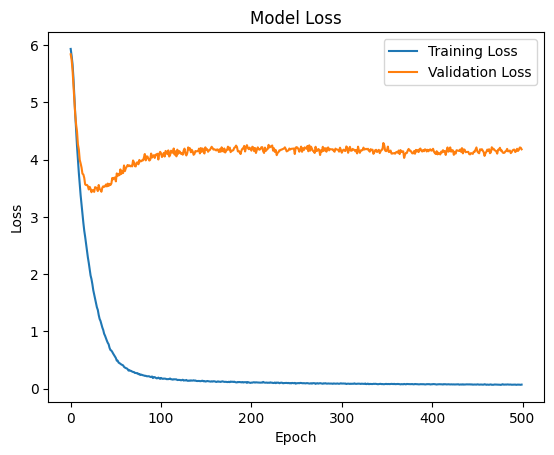

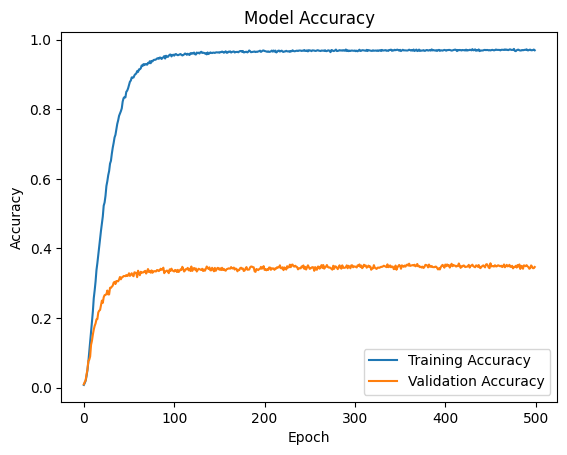

112/112 [==============================] - 16s 137ms/step
Accuracy: 0.34747191011235956
Average Precision: 0.38189290735077164
Average Recall: 0.34160498343596934
Average F1 Score: 0.34301555052961663


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import VGG16

# Define data directories
train_data_dir = r"C:\Users\79894\Downloads\archive2_converted_train"
test_data_dir = r"C:\Users\79894\Downloads\archive2_converted_test"

# Define data generators with preprocessing_function (fixed image size)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of preprocessed images
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),  # Adjusted to match the VGG16 model input shape
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),  # Adjusted to match the VGG16 model input shape
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of VGG16
x = base_model.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
predictions = Dense(355, activation='softmax')(x)  # Adjust output neurons based on your classification task

# Combine base model and custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=SGD(learning_rate=1e-3, momentum=0.9, nesterov=True),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train your model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=500,  # Adjust as needed
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Extract results from the final epoch
final_epoch_results = {
    'loss': history.history['loss'][-1],
    'accuracy': history.history['accuracy'][-1],
    'val_loss': history.history['val_loss'][-1],
    'val_accuracy': history.history['val_accuracy'][-1]
}

# Print the final epoch results
print("Final Epoch Results:")
print(final_epoch_results)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot accuracy history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate the model on test data
validation_generator.reset()  # Reset the generator to start from the beginning
predictions = model.predict(validation_generator, steps=validation_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(validation_generator.classes, predicted_classes)

# Calculate metrics
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)

precision = []
recall = []
f1_score = []

for i in range(355):  # Adjusted based on the number of classes
    true_positives = conf_matrix[i, i]
    false_positives = np.sum(conf_matrix[:, i]) - true_positives
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives

    precision_i = true_positives / (true_positives + false_positives) if true_positives + false_positives != 0 else 0
    recall_i = true_positives / (true_positives + false_negatives) if true_positives + false_negatives != 0 else 0

    precision.append(precision_i)
    recall.append(recall_i)

    # Calculate F1 score
    if precision_i + recall_i != 0:
        f1_score_i = 2 * (precision_i * recall_i) / (precision_i + recall_i)
    else:
        f1_score_i = 0

    f1_score.append(f1_score_i)

# Calculate average precision, recall, and F1 score
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)

# Print the metrics
print("Accuracy:", accuracy)
print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1 Score:", avg_f1_score)
